In [3]:
import torch
import einops
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

import lovely_tensors as lt
lt.monkey_patch()

In [2]:
# Step 1: Load and prepare the graph data
print("Loading graph data...")
graph_data = torch.load('graph_data_new_topology.pt')
print("Graph data loaded successfully!")

Loading graph data...


/tmp/ipykernel_3916002/2504979202.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load('graph_data_new_topology.pt')


Graph data loaded successfully!


In [3]:
graph_data.edge_features = torch.cat([graph_data.edge_features, graph_data.edge_features], dim=0)
edges = torch.cat([graph_data.edge_index[0], graph_data.edge_index[1]])
edges_reversed = torch.stack([reversed(e) for e in edges.reshape(-1, 2)]).flatten()
graph_data.edge_index = torch.stack([edges, edges_reversed])

In [4]:
loc1 = F.one_hot(graph_data.y_location_1.long())[:, 1:]
loc2 = F.one_hot(graph_data.y_location_2.long())[:, 1:]
y = (loc1 + loc2).T
y

tensor[32, 17520000] i64 n=560640000 (4.2Gb) x∈[0, 1] μ=0.008 σ=0.087

In [5]:
graph_data = Data(
    edge_index=graph_data.edge_index,
    num_nodes=graph_data.num_nodes,
    node_features=graph_data.node_features,
    edge_features=graph_data.edge_features,
    y=y
)

In [6]:
graph_data

Data(edge_index=[2, 68], y=[32, 17520000], num_nodes=32, node_features=[32, 17520000], edge_features=[68, 17520000])

In [7]:
torch.save(graph_data, "graph_data_new_topology_preprocessed.pt")

In [14]:
graph_data = torch.load("graph_data_new_topology_preprocessed.pt")

/tmp/ipykernel_1270705/157294050.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load("graph_data_new_topology_preprocessed.pt")


In [15]:
# Step 2: Clip the graph data to the first million data points
num_data_points = 1_000_000  # Define the limit for the data points
graph_data.node_features = graph_data.node_features[:, :num_data_points]
graph_data.edge_features = graph_data.edge_features[:, :num_data_points]
graph_data.y = graph_data.y[:, :num_data_points]

# Verify the updated data shape
print("Updated graph data structure:")
print(f"y: {graph_data.y}")
print(f"node_features: {graph_data.node_features}")
print(f"edge_features: {graph_data.edge_features}")

# Step 3: Reshape node and edge features for GCN
def reshape_for_gcn(data, window_size=20, stride=10):
    """
    Reshape time-series data for GCN format. 
    Returns reshaped data with shape [num_elements, num_windows].
    """
    num_elements, num_timesteps = data.shape
    num_windows = (num_timesteps - window_size) // stride + 1
    
    reshaped_data = torch.zeros((num_elements, num_windows))
    for i in range(num_windows):
        start_idx = i * stride
        end_idx = start_idx + window_size
        reshaped_data[:, i] = data[:, start_idx:end_idx].mean(dim=1)
    
    return reshaped_data

# Reshape node and edge features
print("\nReshaping data for GCN...")
graph_data.node_features = reshape_for_gcn(graph_data.node_features, window_size=20, stride=10)
graph_data.edge_features = reshape_for_gcn(graph_data.edge_features, window_size=20, stride=10)
print(f"Reshaped node features: {graph_data.node_features}")
print(f"Reshaped edge features: {graph_data.edge_features}")

Updated graph data structure:
y: tensor[32, 1000000] i64 n=32000000 (0.2Gb) x∈[0, 1] μ=0.009 σ=0.092
node_features: tensor[32, 1000000] n=32000000 (0.1Gb) x∈[0., 69.984] μ=61.334 σ=11.887
edge_features: tensor[68, 1000000] n=68000000 (0.3Gb) x∈[-2.045e+03, 1.263e+04] μ=841.751 σ=1.522e+03

Reshaping data for GCN...
Reshaped node features: tensor[32, 99999] n=3199968 (12Mb) x∈[0., 69.967] μ=61.334 σ=11.615
Reshaped edge features: tensor[68, 99999] n=6799932 (26Mb) x∈[-1.758e+03, 1.103e+04] μ=841.755 σ=1.479e+03


In [16]:
def aggregate_labels(data, window_size=20, stride=10):
    num_elements, num_timesteps = data.shape
    num_windows = (num_timesteps - window_size) // stride + 1
    
    reshaped_data = torch.zeros((num_elements, num_windows))
    for i in range(num_windows):
        start_idx = i * stride
        end_idx = start_idx + window_size
        reshaped_data[:, i] = data[:, start_idx:end_idx].mean(dim=1) > 0.5
    
    return reshaped_data

    
y = aggregate_labels(graph_data.y.float()).long()
graph_data.y = y

In [17]:
min_edge = graph_data.edge_features.min()
max_edge = graph_data.edge_features.max()

graph_data.edge_features = (graph_data.edge_features - min_edge) / (max_edge - min_edge)

max_nodes = graph_data.node_features.max()
min_nodes = graph_data.node_features.min()

graph_data.node_features = (graph_data.node_features - min_nodes) / (max_nodes - min_nodes)

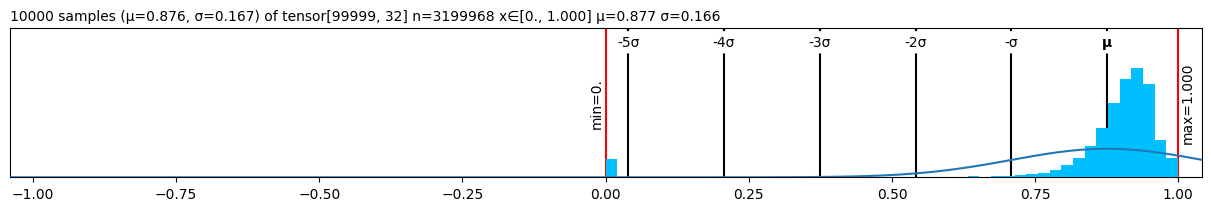

In [294]:
graph_data.node_features.T.plt

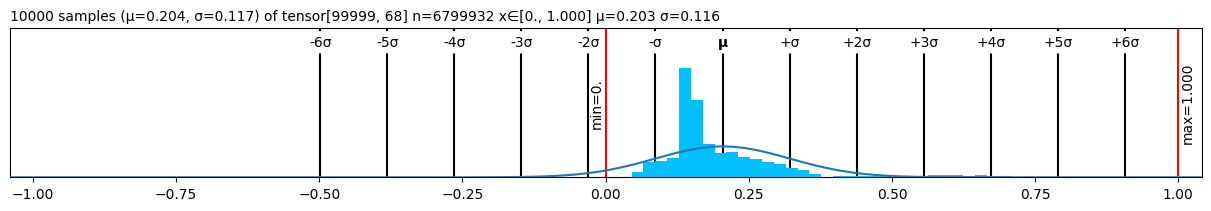

In [295]:
graph_data.edge_features.T.plt

In [20]:
num_graphs = graph_data.y.shape[1]
graphs = []
for i in tqdm(range(num_graphs)):
    graph = Data(
        x=graph_data.node_features[:, i].unsqueeze(1),
        edge_index=graph_data.edge_index,
        edge_attr=graph_data.edge_features[:, i].unsqueeze(1),
        y=graph_data.y[:, i]
    )
    graphs.append(graph)

100%|██████████| 99999/99999 [00:03<00:00, 29315.03it/s]


## Model training

In [355]:
import torch.nn as nn
import pandas as pd

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch.utils.data import WeightedRandomSampler

In [297]:
class FocalLoss(nn.Module):
    def __init__(
        self, gamma: float = 2.0, weights=None
    ):
        super().__init__()
        self.gamma = gamma
        self.weights = weights

        self.reduction = torch.mean

    def __call__(self, x, target):
        ce_loss = F.cross_entropy(x, target, reduction="none")
        pt = torch.exp(-ce_loss)
        
        if self.weights is not None:
            weights = self.weights.to(x.device)[target]
            focal_loss = torch.pow((1 - pt), self.gamma) * weights * ce_loss
        else:
            focal_loss = torch.pow((1 - pt), self.gamma) * ce_loss

        return self.reduction(focal_loss)

In [298]:
NUM_EDGE_FEATURES = 1
NUM_NODE_FEATURES = 1

In [299]:
# Basically the same as the baseline except we pass edge features 
class GDPModel(torch.nn.Module):
    def __init__(self, num_features=3, hidden_size=32, target_size=1, heads=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = nn.ModuleList([
            GATConv(self.num_features, self.hidden_size, edge_dim = NUM_EDGE_FEATURES, dropout=dropout),
            GATConv(self.hidden_size, self.hidden_size, edge_dim = NUM_EDGE_FEATURES, heads=heads, dropout=dropout)])
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        x = self.linear(x)
        return x

In [300]:
graphs[:10]

[Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32]),
 Data(x=[32, 1], edge_index=[2, 68], edge_attr=[68, 1], y=[32])]

In [344]:
TEST_SIZE = 0.2
train_graphs, test_graphs = train_test_split(
    graphs, 
    test_size=TEST_SIZE
    )
print("Train Graph Data")
print(len(train_graphs))
print("Test Graph Data")
print(len(test_graphs))

Train Graph Data
79999
Test Graph Data
20000


In [346]:
_, (zeros, ones) = torch.stack([elem.y for elem in train_graphs]).flatten().unique(return_counts=True)
total_labels = zeros + ones
weights = torch.tensor([total_labels / (2*zeros), total_labels / (2*ones)])
sample_weights = 1 - torch.tensor([zeros / total_labels, ones / total_labels])
print(f"Weights {weights}")
print(f"Sample Weights {sample_weights}")

Weights tensor[2] μ=29.715 σ=41.310 [0.504, 58.926]
Sample Weights tensor[2] μ=0.500 σ=0.695 [0.008, 0.992]


In [302]:
from sklearn.metrics import classification_report, confusion_matrix

In [303]:
def evaluate_model(model, loss_fn, val_data):
    print("================ VALIDATION ================")
    batch_size = len(val_data)
    loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    data = next(iter(loader))
    with torch.no_grad():
        y_pred = model(data)
    
    y_pred_node = y_pred.argmax(dim=1)
    y_pred_leak = einops.rearrange(y_pred_node, "(b n) -> b n", b=batch_size)
    y_true = einops.rearrange(data.y, "(b n) -> b n", b=batch_size)
    
    y_pred_leak = (y_pred_leak.sum(dim=1) > 0).int()
    y_true_leak = (y_true.sum(dim=1) > 0).int()
    print("---------------- GRAPH LEVEL ----------------")
    print(classification_report(y_true_leak, y_pred_leak, zero_division=0.0))
    print(pd.DataFrame(confusion_matrix(y_true_leak, y_pred_leak), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print("---------------- NODE LEVEL ----------------")
    print(classification_report(data.y, y_pred_node, zero_division=0.0))
    print(pd.DataFrame(confusion_matrix(data.y, y_pred_node), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print("================================")
    loss = loss_fn(y_pred, data.y)
    return loss
            

In [373]:
def train(model, loss_fn, name_prefix, hyperparams):
    ''' 
    Train model with given hyperparams dict.
    Saves the following CSVs over the course of training:
    1. the loss trajectory: the val and train loss every save_loss_interval epochs at
       filename 'results/{name_prefix}_{learning_rate}_train.csv' e.g. 'results/baseline_0.05_train.csv'
    2. every save_model_interval save both the model at e.g. 'models/baseline_0.05_0_out_of_1000.pt`
       and the predicted values vs actual values in `results/baseline_0.05_0_out_of_1000_prediction.csv' on the test data.
    '''
    model = model.train()
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    weight_decay = hyperparams['weight_decay']
    sampler_elements = hyperparams["sampler_elements"]
    #
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    save_model_interval = hyperparams['save_model_interval']
    bar_update_interval = 1
    
    sampler = None
    if sampler_elements > 0:
        print("Using sampler")
        sampling_prob = sample_weights[torch.stack([elem.y.any() for elem in train_graphs]).int()]
        sampler = WeightedRandomSampler(sampling_prob, sampler_elements)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
    losses = []
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        epoch_loss = 0
        model.train()
        bar = tqdm(loader)
        for idx, data in enumerate(bar):
            optimizer.zero_grad()
            out = model(data)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() 
            if idx % bar_update_interval == 0:
                bar.set_postfix({"loss": loss.item()})
        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, loss_fn, test_graphs) / len(test_graphs)
            train_loss = epoch_loss / len(train_graphs) * batch_size
            if epoch % print_interval == 0:
                print("Epoch: {} Train loss: {:.2e} Validation loss: {:.2e}".format(epoch, train_loss, val_loss))
            losses.append((epoch, train_loss, val_loss))
        if epoch % save_model_interval == 0:
            # save predictions for plotting
            model.eval()
        print(loss)

    return losses

In [378]:
hyperparameters = dict(
    learning_rate=0.0001,
    n_epochs=5,
    batch_size=512,
    weight_decay=1e-4,
    sampler_elements=10000,
    #
    save_loss_interval=1,
    print_interval=1,
    save_model_interval=1,
)

In [379]:
model = GDPModel(num_features=NUM_NODE_FEATURES, hidden_size=16, target_size=2, heads=1, dropout=0.5)
loss_fn = FocalLoss(weights=None, gamma=1.0)
train(model, loss_fn, "", hyperparameters)

Using sampler


Epoch 0


100%|██████████| 20/20 [01:56<00:00,  5.83s/it, loss=0.512]


================ VALIDATION ================


KeyboardInterrupt: 

In [368]:
sampling_prob = sample_weights[torch.stack([elem.y.any() for elem in train_graphs]).int()]
sampler = WeightedRandomSampler(sampling_prob, 10_000)
loader = DataLoader(train_graphs, batch_size=512, sampler=sampler)

ValueError: sampler option is mutually exclusive with shuffle